# AntennaAnalytics-Arg

La idea es usar el monthly sumLinks output (los sframe dirs dentro de `/output/year/month/sum_links3`) donde tenemos un dataframe de estilo SumLinks con con el siguiente header (solo considerando _OUTgoing calls)

USER|VULNERABLE|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend

CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI

el equivalente al sumlinks de mexico que cuenta agrega todas las llamadas salientes de un user y resume su informacion de comunicacion

El output tendria que tener el siguiente header:
ANTENNA_ID|USERS|VULN_USERS|CALLS|VULN_CALLS

CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend

CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI

## definiciones utilizadas

* *Time* columns are measured in seconds, all other columns are in counts (except the antenna_id cols)
* el analisis es solo para CDRs con usuarios de la TelCo.
* el formato del string para el ANTENNA_ID difiere del raw dataset en que se borro el ultimo char para todas las raw antennas (resultaba que el ultimo char era a veces distinto para una misma antenna)
* el Antenna_id_0 p/c/ user viene dado por el analisis del home_mapping_antenna donde le asignamos una antenan de home en base al uso de las antennas segun un horario particular p/c/user

### la idea es llegar a algo similar a esto
pero sin la info de sms

In [1]:
!head /home/juan/mobility-study/data/mexico_ant2vuln_aggregation.txt

ANTENNA_ID_0|TOTAL_USERS|EPI_USERS|EXP_USERS|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|CallsWeekDaylight_EPI|CallsWeekNight_EPI|CallsWeekend_EPI|TOTAL_Calls|TOTAL_EPI_Calls|TimeWeekDaylight_EPI|TimeWeekNight_EPI|TimeWeekend_EPI|TOTAL_Time|TOTAL_EPI_Time
1|862|338|818|12787|6178|5944|1352028|822011|750888|2474|1332|1208|29923|5014|296803|190709|176422|3588861|663934
2|1106|386|1029|13043|7436|7097|1605549|1025268|832785|2778|1493|1629|33476|5900|361363|228168|197412|4250545|786943
3|948|418|913|18401|8966|8421|2204147|1321580|960480|3767|1891|1621|43067|7279|467231|253443|193268|5400149|913942
4|629|262|602|8878|5733|5691|1166484|992407|729013|2835|1377|1480|25994|5692|341738|216970|201343|3647955|760051
5|506|221|491|5678|3487|3711|612525|427256|417892|1229|902|974|15981|3105|140848|108824|113230|1820575|362902
6|590|283|577|8544|4278|4375|989851|614566|474512|2428|1191|1259|22075|4878|324709|183312|148915|2735865|656936
7|1763|947|1726|21

## Read Sframes

In [1]:
import pandas as pd;
import numpy as np;
import os;
import random;
import graphlab as gl
import time
import datetime
import sys
import subprocess
pd.set_option('display.max_rows', 200)
#esto es para dibujar directo a la notebook
gl.canvas.set_target('ipynb')
rootdir="/home/juan/mobility-study/mexico-scripts-ver2/"
os.chdir(rootdir)

#los meses a analizar
ms = [8,9,10,11,12]

def get_output_file(month, direc='O'):    
    if direc == 'O': direc = 'out'
    elif direc == 'I': direc = 'in'
    else: 
        print('direction is %s , should be O or I ' % direc)
        return 0
    output_file = "/home/juan/mobility-study/mexico-scripts-ver2/output/{m:0=2d}/antenna_usage_aggregation_{di}.csv".\
    format(m = month,di=direc)
    return output_file

def get_input_url(month):
    input_url = "/home/juan/mobility-study/mexico-scripts-ver2/output/sum_links1_month{0:0=2d}2015_sframe".\
    format(month)
    return input_url

/home/juan/mobility-study/scikit-learn/sklearn/externals/joblib/_multiprocessing_helpers.py:29: UserWarning: [Errno 38] Function not implemented.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
A newer version of GraphLab Create (v2.0.1) is available! Your current version is v1.8.5.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


# set global script params

In [2]:
month = 11
direc = 'I'
month,direc

(11, 'I')

In [4]:
!ls output/

08
09
10
11
12
antenna_usage.tar
homeantenna_from0114to0715_sframe_short_group0_1
homeantenna_from0114to0715_sframe_short_group1_1
homeantenna_from0114to0715_sframe_short_group2_1
homeantenna_from0114to0715_sframe_short_group3_1
homeantenna_from0114to0715_sframe_short_group4_1
homeantenna_from0114to0715_sframe_short_group5_1
homeantenna_from0114to0715_sframe_short_group6_1
homeantenna_from0114to0715_sframe_short_group7_1
homeantenna_from0114to0715_sframe_short_group8_1
homeantenna_from0114to0715_sframe_short_group9_1
homeantenna_from0114to0715_sframe_short_gtruth
homeantenna_from0215to0715_sframe_gtruth_group0_1
homeantenna_from0815to1215_sframe_2
homeantenna_from0815to1215_sframe_full_group0_1
homeantenna_from0815to1215_sframe_full_group1_1
homeantenna_from0815to1215_sframe_full_group2_1
sum_links1_month082015_sframe
sum_links1_month092015_sframe
sum_links1_month102015_sframe
sum_links1_month112015_sframe
sum_links1_month122015_sframe
sum_links2_month082015_sframe
sum_links2_month0920

# Load antenna lat/long data

In [5]:
antennas_file = '/home/juan/mobility-study/mexico-scripts-ver2/data/celdas_limpio.csv'
    #obs el column_type str para el cel_id es para que matchee con el column_type que tengo en home_antenna ya y en table
antennas = gl.SFrame.read_csv('data/celdas_limpio.csv', 
                                  delimiter= "|"
                                  ,usecols = ['CEL_ID','EPIDEMIC'],
                                  column_type_hints = [str,bool])

This non-commercial license of GraphLab Create is assigned to svega@dm.uba.ar and will expire on April 16, 2017. For commercial licensing options, visit https://turi.com/buy/.


2016-07-14 03:16:53,922 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1468466213.log


Finished parsing file /home/juan/mobility-study/mexico-scripts-ver2/data/celdas_limpio.csv

Parsing completed. Parsed 4415 lines in 0.048739 secs.

## Cargar el home antenna mapping p/c/ user en todo el espacio temporal

In [7]:
homeantenna_dirs = [x[0] for x in os.walk('output/') if ("homeantenna_from0815to1215" in x[0] and not("sample" in x[0]))]
homeantenna_dirs


['output/homeantenna_from0815to1215_sframe_full_group2_1',
 'output/homeantenna_from0815to1215_sframe_2',
 'output/homeantenna_from0815to1215_sframe_full_group1_1',
 'output/homeantenna_from0815to1215_sframe_full_group0_1']

In [8]:
%%time
##read homeantenna_data
homeantenna_map =  gl.SFrame()

for home_dir in homeantenna_dirs:
    group_map = gl.load_sframe(home_dir)
    group_map = group_map['USER','ANTENNA_ID_WEEKNIGHT_0']
    #users with str(-1) values are those for which no calls were recorded in that period, thus we have to discard them
    group_map = group_map[group_map['ANTENNA_ID_WEEKNIGHT_0']!='-1']
    homeantenna_map = homeantenna_map.append(group_map)

print(homeantenna_map.shape)

(3895670, 2)
CPU times: user 9.46 s, sys: 640 ms, total: 10.1 s
Wall time: 15.2 s


# consistency check:
we may have multiple users in the same mapping

In [9]:
print(homeantenna_map.shape, len(homeantenna_map['USER'].unique()))

((3895670, 2), 1947835)


In [10]:
homeantenna_map.head()

USER,ANTENNA_ID_WEEKNIGHT_0
8FBC70E3A3E80885EF25D7743C300DFF ...,1939
F0B0096ECFBAD2FC97FD159A88238257 ...,412
79FA951F80A4962919140653A02E0696 ...,475
65F9DB3D50172B79416004DCB2377E27 ...,3500
D402A8E2F22841A83ED6B98531790E99 ...,4252
FF27B255AF646BA81AB9FAC31AFE4A92 ...,1820
1337A4E6E56006D2AFD154CF16B2A775 ...,3132
59229DB0476060538EA465F67FE5728F ...,2173
BF3FCCC6A6709414EC25612FFEDAF020 ...,2535
90AC003122B6026A4C9CF2A0347228FD ...,2915


In [11]:
# set Load params

input_dir =  get_input_url(month = month)
antenna_output =  get_output_file(month,direc)
print(antenna_output)
!du -sh $input_dir
!ls output/

/home/juan/mobility-study/mexico-scripts-ver2/output/11/antenna_usage_aggregation_in.csv
735M	/home/juan/mobility-study/mexico-scripts-ver2/output/sum_links1_month112015_sframe
08
09
10
11
12
antenna_usage.tar
homeantenna_from0114to0715_sframe_short_group0_1
homeantenna_from0114to0715_sframe_short_group1_1
homeantenna_from0114to0715_sframe_short_group2_1
homeantenna_from0114to0715_sframe_short_group3_1
homeantenna_from0114to0715_sframe_short_group4_1
homeantenna_from0114to0715_sframe_short_group5_1
homeantenna_from0114to0715_sframe_short_group6_1
homeantenna_from0114to0715_sframe_short_group7_1
homeantenna_from0114to0715_sframe_short_group8_1
homeantenna_from0114to0715_sframe_short_group9_1
homeantenna_from0114to0715_sframe_short_gtruth
homeantenna_from0215to0715_sframe_gtruth_group0_1
homeantenna_from0815to1215_sframe_2
homeantenna_from0815to1215_sframe_full_group0_1
homeantenna_from0815to1215_sframe_full_group1_1
homeantenna_from0815to1215_sframe_full_group2_1
sum_links1_month082015_

In [12]:
#cargar input_table
table = gl.load_sframe(input_dir)

table.head()

DIRECTION,OTHER_USER,USER,CallsWeekEnd,CallsWeekNight,CallsWeekDay
I,25A22E755139949C100693BFE54BBF21 ...,AF93BFEABC04390BD0040ADA471136BD ...,5,7,18
O,395DD8AF16C3516B44A6DF42FAC2891B ...,72E49BE3BC07E033BDCCFF6362267090 ...,None,None,2
O,D8DE5FD13B17E2DE4895A4A304D37782 ...,49D229ACC9E4E415B8CDF4D497C03DF8 ...,2,8,12
O,E749D1FA1BBF41F1B80463600F217344 ...,50401BF8AB49DA618FEE241A6F9F8FFB ...,None,None,3
I,ABA5146F18ACAAA17DC76B0068AD0525 ...,535883ED15226F7F39EC72A5C11D74F9 ...,None,None,1
I,27DDB9B704D5A87249F0A23D43BA0578 ...,CAA58FEF220256E5C2DE8314030B6563 ...,None,None,2
I,FA2B38EA0FCECFC2CBD248F24179D7EE ...,0671F42182DCBE3BB9253EBAA400BDAB ...,1,None,6
I,402B81601A41E056CD1F85A5D584D416 ...,AA2DE98FCE998362BB773BACB8A2D72B ...,1,None,1
O,AB044428A1E3019E74A9643BB2A0BC37 ...,7DAF0C06E92678ECC663F0309598FFED ...,None,None,1
I,6C752AB33A4A9AAB45F4A07CFF29C0CF ...,C647BB5BF7615DDC133F0EB5CA828080 ...,2,2,4


In [13]:
%%time
# dependiendo de la direccion como etiqueto las antennas.
if direc == 'O':
    table = table.rename({'EPIDEMIC':'VULNERABLE'}) #USER es vulnerable si el OTHER_USER es epidemic
    table = table.rename({'EPIDEMIC.0':'EPIDEMIC'})#USER es EPIDEMIC si su antenna es EPIDEMIC

elif direc == 'I':
    table = table.rename({'EPIDEMIC.0':'VULNERABLE'})#USER es EPIDEMIC si su antenna es EPIDEMIC
    table = table.rename({'EPIDEMIC':'EPIDEMIC'}) #USER es vulnerable si el OTHER_USER es epidemic
    #y tambien tenemos que swappear el origin y el target user (USER vs OTHER_USER)
    table = table.rename({'USER':'USER2', 'OTHER_USER':'OTHER_USER2'})
    table = table.rename({'USER2':'OTHER_USER', 'OTHER_USER2':'USER'})

    
#me quedo solamente con los llamados salientes y tiro la columna
table = table[table['DIRECTION'] == direc]
table = table.remove_column('DIRECTION')

#FAST analytics
print(table.shape, (table['VULNERABLE']==table['EPIDEMIC']).sum())

((5168117, 10), 4831368)
CPU times: user 32.4 s, sys: 3.25 s, total: 35.7 s
Wall time: 14.4 s


# segmento llamados por vulnerables y no vulnerables p/c/user
Nota, aca ya cambiamos la definicion utilizada en la version anterior del procesamiento p/Mexico

In [14]:
%%time
table_epi = table[table['VULNERABLE']==1]

table_epi = table_epi.groupby('USER',
                {'CallsWeekEnd':gl.aggregate.SUM('CallsWeekEnd'),
                 'CallsWeekNight':gl.aggregate.SUM('CallsWeekNight'),
                'CallsWeekDay':gl.aggregate.SUM('CallsWeekDay'),
                'TimeWeekEnd':gl.aggregate.SUM('TimeWeekEnd'),
                'TimeWeekNight':gl.aggregate.SUM('TimeWeekNight'),
                'TimeWeekDay':gl.aggregate.SUM('TimeWeekDay')}
                             )

rename_dict =  dict([(col,col+"_VUL") if not('USER' in col) else (col,col) for col in table_epi.column_names() ])
rename_dict

CPU times: user 16.2 s, sys: 724 ms, total: 16.9 s
Wall time: 4.87 s


In [15]:
table_epi.rename(rename_dict)
table_epi['VULNERABLE'] = 1

In [16]:
%%time
table = table[table['VULNERABLE']==0]
table = table.groupby('USER',
                {'CallsWeekEnd':gl.aggregate.SUM('CallsWeekEnd'),
                 'CallsWeekNight':gl.aggregate.SUM('CallsWeekNight'),
                'CallsWeekDay':gl.aggregate.SUM('CallsWeekDay'),
                'TimeWeekEnd':gl.aggregate.SUM('TimeWeekEnd'),
                'TimeWeekNight':gl.aggregate.SUM('TimeWeekNight'),
                'TimeWeekDay':gl.aggregate.SUM('TimeWeekDay')}
                             )

CPU times: user 44.8 s, sys: 844 ms, total: 45.6 s
Wall time: 11.7 s


In [17]:
%%time
table = table.join(table_epi, on = 'USER' ,how='outer')
#check consistency of unique users
print(table.shape, len(table['USER'].unique()))

((1393889, 14), 1393889)
CPU times: user 18.5 s, sys: 256 ms, total: 18.7 s
Wall time: 7.3 s


In [18]:
# relleno los nulls
for col in table.column_names():
    if col == 'USER':
        continue
    count_nulls = table[ table[col] == None ]
    print('amount of nulls for column {c} is {p}'.format(c = col, p =str(count_nulls.shape) ))
    table = table.fillna(col, 0)

amount of nulls for column TimeWeekEnd is (309428, 14)
amount of nulls for column CallsWeekDay is (309428, 14)
amount of nulls for column CallsWeekNight is (309428, 14)
amount of nulls for column TimeWeekDay is (309428, 14)
amount of nulls for column CallsWeekEnd is (309428, 14)
amount of nulls for column TimeWeekNight is (309428, 14)
amount of nulls for column TimeWeekEnd_VUL is (943946, 14)
amount of nulls for column CallsWeekDay_VUL is (943946, 14)
amount of nulls for column CallsWeekNight_VUL is (943946, 14)
amount of nulls for column TimeWeekDay_VUL is (943946, 14)
amount of nulls for column CallsWeekEnd_VUL is (943946, 14)
amount of nulls for column TimeWeekNight_VUL is (943946, 14)
amount of nulls for column VULNERABLE is (943946, 14)


In [18]:
table.head()

USER,TimeWeekEnd,CallsWeekDay,CallsWeekNight,TimeWeekDay,CallsWeekEnd,TimeWeekNight
23D263FD33D5B9CEE090AD9587BD5E45 ...,35,8,4,1276,4,425
6E9B40DE6F44190A2B2D9D83D9932078 ...,446,17,6,2681,12,299
C07C13F0890B301A5B2EA0D41808A3BC ...,2161,40,2,3612,26,130
BB8CAD1367F30EE7369B60BA756A0EE2 ...,74,17,6,1553,2,2151
E8D6E471AD8705240E223E8F3483486D ...,187,2,1,152,3,393
7BD0CC528F1F55536D4CB385E0C75365 ...,154,0,0,0,3,0
AD5C4626FBC105FB6C4D5A270C4D21FB ...,3026,41,19,5779,17,1839
4EF7B5616FB23C87A91A56434FEA4445 ...,0,4,0,499,0,0
D81B416174A5A9F48FD53D1A713C9CC4 ...,178,18,3,823,6,339
A5713009D1BA660A04234A098D81E301 ...,12,19,3,1191,1,125


In [19]:
aggregator_dict = dict()
for col in table.column_names():
    if col == 'ANTENNA_ID_WEEKNIGHT_0':
        continue
    if 'USER' in col:
        aggregator_dict[col] = gl.aggregate.COUNT_DISTINCT(col) # con esto voy a contar la cantidad de usuarios que llaman desde
#esta antenna y la cantidad de users que fueron llamados por esta antenna
    else:
        aggregator_dict[col] = gl.aggregate.SUM(col)
aggregator_dict

{'CallsWeekDay': ('__builtin__sum__', ['CallsWeekDay']),
 'CallsWeekDay_VUL': ('__builtin__sum__', ['CallsWeekDay_VUL']),
 'CallsWeekEnd': ('__builtin__sum__', ['CallsWeekEnd']),
 'CallsWeekEnd_VUL': ('__builtin__sum__', ['CallsWeekEnd_VUL']),
 'CallsWeekNight': ('__builtin__sum__', ['CallsWeekNight']),
 'CallsWeekNight_VUL': ('__builtin__sum__', ['CallsWeekNight_VUL']),
 'TimeWeekDay': ('__builtin__sum__', ['TimeWeekDay']),
 'TimeWeekDay_VUL': ('__builtin__sum__', ['TimeWeekDay_VUL']),
 'TimeWeekEnd': ('__builtin__sum__', ['TimeWeekEnd']),
 'TimeWeekEnd_VUL': ('__builtin__sum__', ['TimeWeekEnd_VUL']),
 'TimeWeekNight': ('__builtin__sum__', ['TimeWeekNight']),
 'TimeWeekNight_VUL': ('__builtin__sum__', ['TimeWeekNight_VUL']),
 'USER': ('__builtin__count__distinct__', ['USER']),
 'VULNERABLE': ('__builtin__sum__', ['VULNERABLE'])}

In [20]:
%%time
# mergeamos con home_antenna data p/agregar info de las celdas
table = table.join(homeantenna_map, on = 'USER' )

CPU times: user 33.8 s, sys: 1.62 s, total: 35.4 s
Wall time: 17.2 s


In [21]:
col = 'ANTENNA_ID_WEEKNIGHT_0'
count_nulls = table[ table[col] == None ]
print('amount of nulls for column {c} is {p}'.format(c = col, p =str(count_nulls.shape) ))

amount of nulls for column ANTENNA_ID_WEEKNIGHT_0 is (0, 15)


## agregado por antenna, vulnerable habla de
cuantos users en esa antenna tuvieron algun contacto con un OTHER_USER epidemico (que puede ser el mismo across different users)

In [22]:
%%time
antenna_usage = table.groupby('ANTENNA_ID_WEEKNIGHT_0', aggregator_dict)

CPU times: user 28.3 s, sys: 456 ms, total: 28.7 s
Wall time: 5.28 s


In [23]:
# renombro columnas para tener consistencia con otras tablas
antenna_usage.rename({'ANTENNA_ID_WEEKNIGHT_0':'CEL_ID', 
                     'VULNERABLE':'VULN_USERS',
                     'USER':'USERS'})

CEL_ID,TimeWeekDay_VUL,TimeWeekEnd,CallsWeekDay,CallsWeekNight,TimeWeekNight_VUL,CallsWeekDay_VUL
144,90563,252521,6620,1654,55749,523
3254,75092,1398,32,6,15483,655
4146,383319,19288,302,91,171846,3244
3673,50726,315615,9980,2125,55603,297
1218,248070,3741,71,22,49160,2576
1580,566377,48276,327,95,294897,6054
4044,26185,55382,1552,244,7377,179
2800,310803,13601,360,55,55064,3735
1849,3191,5243,32,22,1656,27
2769,11654,0,4,0,828,173


In [24]:
call_columns = [col for col in antenna_usage.column_names() if "Call" in col ]
epi_call_columns = [col for col in antenna_usage.column_names() if "Call" in col and("_VUL" in col)]
print(call_columns, epi_call_columns)

antenna_usage['CALLS']= antenna_usage[call_columns]\
            .apply(lambda x: sum([ x[col] for col in call_columns ]) )
antenna_usage['VULN_CALLS']= antenna_usage[epi_call_columns]\
            .apply(lambda x: x[epi_call_columns[0]]+ x[epi_call_columns[1]]+ x[epi_call_columns[2]] )

(['CallsWeekDay', 'CallsWeekNight', 'CallsWeekDay_VUL', 'CallsWeekEnd_VUL', 'CallsWeekEnd', 'CallsWeekNight_VUL'], ['CallsWeekDay_VUL', 'CallsWeekEnd_VUL', 'CallsWeekNight_VUL'])


In [25]:
## consitency check
(antenna_usage['CALLS']>=antenna_usage['VULN_CALLS']).all(), (antenna_usage['USERS']>=antenna_usage['VULN_USERS']).all()

(True, True)

In [3]:
month = 8
direc = 'O'
month, direc

(8, 'O')

In [4]:
antenna_output = get_output_file(month,direc)
antenna_output

'/home/juan/mobility-study/mexico-scripts-ver2/output/08/antenna_usage_aggregation_out.csv'

In [5]:
#save this version of database
antenna_usage.export_csv(antenna_output, delimiter='|') 
antenna_output

NameError: name 'antenna_usage' is not defined

In [6]:
!head $antenna_output
!wc -l $antenna_output
!du -ha $antenna_output

CEL_ID|TimeWeekDay_VUL|TimeWeekEnd|CallsWeekDay|CallsWeekNight|TimeWeekNight_VUL|CallsWeekDay_VUL|TimeWeekDay|CallsWeekEnd_VUL|USERS|CallsWeekEnd|CallsWeekNight_VUL|TimeWeekNight|TimeWeekEnd_VUL|VULN_USERS|CALLS|VULN_CALLS
144|81388|264140|5857|1524|31337|412|745872|132|338|2107|121|243835|17932|56|10153|665
3254|77851|956|20|8|20482|626|3177|217|21|5|123|1732|29242|21|999|966
4146|566751|26144|302|78|226842|4633|49851|2265|233|163|1369|16320|355815|228|8810|8267
3673|51989|408158|9543|2087|40380|345|1286339|130|506|2899|128|400188|16629|67|15132|603
1218|360192|7687|28|25|94644|3696|4247|1655|160|49|816|5537|168712|160|6269|6167
1580|824710|24854|256|133|289204|7148|51919|2922|344|121|1687|45618|362896|338|12267|11757
4044|21553|55577|1259|297|5869|127|234211|47|74|413|28|55923|7963|14|2171|202
2800|443535|17824|333|56|81848|4351|52722|1881|202|94|746|15683|200843|193|7461|6978
1849|4073|331|4|0|10132|20|542|40|5|6|22|0|17934|5|92|82
4079 /home/juan/mobility-study/mexico-scripts-ver2/

# fast load for analytics

In [7]:
antenna_usage = pd.read_csv(antenna_output, sep='|', index_col='CEL_ID',)

In [8]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("cubehelix", 8)

This non-commercial license of GraphLab Create is assigned to svega@dm.uba.ar and will expire on April 16, 2017. For commercial licensing options, visit https://turi.com/buy/.


2016-07-14 04:37:42,317 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1468471061.log


In [17]:
%matplotlib inline

In [9]:
antenna_usage.head(0)

,TimeWeekDay_VUL,TimeWeekEnd,CallsWeekDay,CallsWeekNight,TimeWeekNight_VUL,CallsWeekDay_VUL,TimeWeekDay,CallsWeekEnd_VUL,USERS,CallsWeekEnd,CallsWeekNight_VUL,TimeWeekNight,TimeWeekEnd_VUL,VULN_USERS,CALLS,VULN_CALLS
CEL_ID,,,,,,,,,,,,,,,,


In [45]:
antenna_usage['USERS'].describe(percentiles =[0.05,0.5,0.75,0.95,0.99])

count    4109.000000
mean      339.228279
std       373.534530
min         1.000000
5%          3.000000
50%       218.000000
75%       517.000000
95%      1070.600000
99%      1569.000000
max      3043.000000
Name: USERS, dtype: float64

In [46]:
antenna_usage['VULN_USERS'].describe(percentiles =[0.05,0.5,0.75,0.95,0.99])

count    4109.000000
mean      109.501825
std       229.993278
min         0.000000
5%          0.000000
50%        26.000000
75%        77.000000
95%       615.600000
99%      1132.960000
max      2932.000000
Name: VULN_USERS, dtype: float64

(4078, 16)


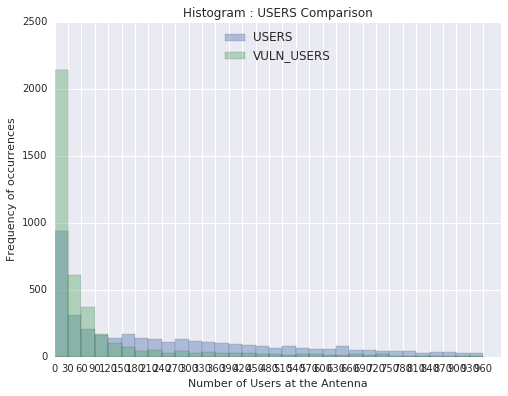

In [21]:
iterator_list = ['USERS', 'VULN_USERS']
#segment_col = 'application_id'
agg_col = 'USERS'
quant = 0.99

fig, ax = plt.subplots(figsize=(8, 6))

#cambio los ejes x
right_xlim = 1000
new_xlim  = (ax.get_xlim()[0],right_xlim)
ax.set_xlim(new_xlim)

# filter 
res = antenna_usage.copy()
print(res.shape)

#draw
bin_width = 30
bins = [i*bin_width for i in range(int(right_xlim/bin_width))]
#print(bins)
for i,item in enumerate(iterator_list):

    #iterating, with more categorical filters, same numerical filters
    res2 = res[res[agg_col] < res[agg_col].quantile(quant)]
    res2 = res[item]
    res2 = res2[res2 < right_xlim]

    sns.distplot(res2, bins=bins, ax=ax, kde=False, norm_hist=False,
                 label='{s}'.format(s= item,color = palette[i] ))


#agrego los bordes de los bins como xticks tambien
plt.xticks(bins, bins)    
    
#agrego la leyend
legend = ax.legend(loc='upper center', shadow=True)
#  .hist(bins =40, color = palette[0], label = 'all_data')

# Set the legend fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

#for label in legend.get_lines():
#    label.set_linewidth(1.5)


ax.set_xlabel('Number of Users at the Antenna');
ax.set_ylabel('Frequency of occurrences');

ax.set_title('Histogram : {ag} Comparison'\
              .format(ag = agg_col));

plt.show()



In [29]:
perc = 0.98
col = 'USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4109     |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |     3043.0    |   Yes    |
|        Mean        | 339.228279387 |   Yes    |
|        Sum         |   1393889.0   |   Yes    |
|      Variance      | 139494.088069 |   Yes    |
| Standard Deviation |  373.48907356 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      1081     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+----+----+----+----+----+----+----+----+----+----+
| value | 1  | 2  | 4  | 3  | 5  | 10 | 6  | 7  | 8  | 13 |
+-------+----+----+----+----+----+----+----+----+----+----+
| count | 90 | 73 | 58 | 55 | 49 | 42 | 41 | 38 | 34 | 33 |
+-------+----+----+----+----+----+----+----+----+----+----+

Quantiles: 
+-----+-----+-

In [30]:
perc = 0.98
col = 'VULN_USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4109     |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         |     2932.0    |   Yes    |
|        Mean        | 109.501825262 |   Yes    |
|        Sum         |    449943.0   |   Yes    |
|      Variance      | 52884.0343724 |   Yes    |
| Standard Deviation | 229.965289495 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      594      |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+-----+-----+-----+-----+-----+----+----+----+----+
| value |  0  |  1  |  2  |  3  |  4  |  5  | 6  | 8  | 7  | 12 |
+-------+-----+-----+-----+-----+-----+-----+----+----+----+----+
| count | 291 | 241 | 164 | 127 | 104 | 104 | 86 | 73 | 70 | 68 |
+-------+-----+-----+-----+-----+-----+-----+----+----+----+---

In [31]:
perc = 0.98
col = 'CALLS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4109     |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |    221961.0   |   Yes    |
|        Mean        | 10459.6899489 |   Yes    |
|        Sum         |   42978866.0  |   Yes    |
|      Variance      | 157219357.767 |   Yes    |
| Standard Deviation | 12538.7143586 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      3509     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+----+---+---+----+----+---+----+----+----+----+
| value | 4  | 1 | 5 | 44 | 57 | 2 | 14 | 79 | 33 | 58 |
+-------+----+---+---+----+----+---+----+----+----+----+
| count | 10 | 8 | 8 | 7  | 6  | 6 | 6  | 6  | 6  | 5  |
+-------+----+---+---+----+----+---+----+----+----+----+

Quantiles: 
+-----+-----+------+--------+

# VULN users to users ratio

In [32]:
perc = 0.98
col = 'USERS'
vuln_col = 'VULN_USERS'

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)


a = antenna_usage[antenna_usage[col]<quant][col]
b = antenna_usage[antenna_usage[col]<quant][vuln_col]

(b/a).show()

In [33]:
perc = 0.98
col = 'CALLS'
vuln_col = 'VULN_' + col

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)


a = antenna_usage[antenna_usage[col]<quant][col]
b = antenna_usage[antenna_usage[col]<quant][vuln_col]

(b/a).show()

# paso a trabajar con pandas y seaborn


In [147]:

import seaborn as sns
antenna_usage = antenna_usage.to_dataframe()
color_palette = sns.color_palette()
#sns.palplot(color_palette)
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

%matplotlib inline

ImportError: Gtk3 backend requires pygobject to be installed.

In [98]:
quant = 0.98

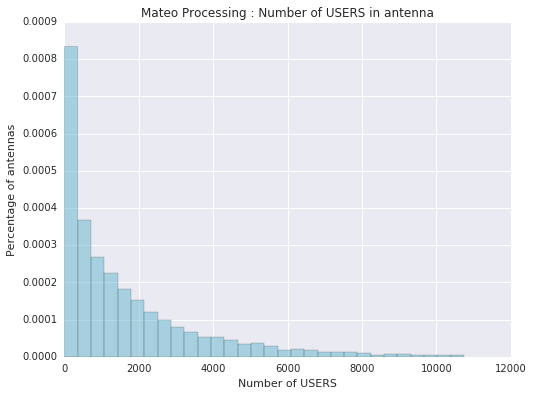

In [99]:
col = 'USERS'
vuln_col = 'VULN_' + col
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('Number of {c}'.format(c=col));
ax.set_ylabel('Percentage of antennas');
ax.set_title('Mateo Processing : Number of {c} in antenna'.format(c = col))

#ax.set_title('Argentina antenna\'s normed histogram : Time_delta (click to install) for lieferheld ios 888\
# where clicks are from {pd.month}/{pd.day} to {sd.month}/{sd.day}'\
#              .format(pd = past_date, sd = start_date));
#ax.legend();



(antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]).hist(bins=30,normed =True, 
                color = color_palette[5], alpha = 0.5)

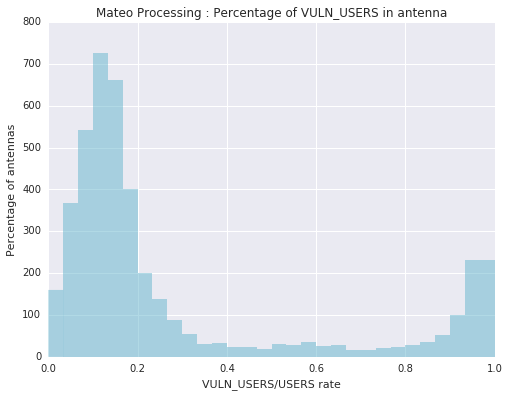

In [131]:
quant = 0.98
col = 'USERS'
vuln_col = 'VULN_' + col
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('{vc}/{c} rate'.format(c=col, vc = vuln_col));
ax.set_ylabel('Percentage of antennas');

ax.set_title('Mateo Processing : Percentage of {vc} in antenna'.format(vc = vuln_col))

a = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]
b = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = False, 
                  color = color_palette[5], alpha = 0.5, lw = 0)


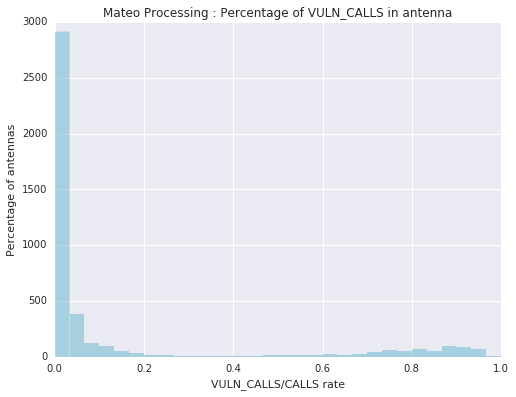

In [132]:
quant = 0.98
col = 'CALLS'
vuln_col = 'VULN_' + col

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('{vc}/{c} rate'.format(c=col, vc = vuln_col));
ax.set_ylabel('Percentage of antennas');

ax.set_title('Mateo Processing : Percentage of {vc} in antenna'.format(vc = vuln_col))

a = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][col]
b = antenna_usage[antenna_usage[col] < antenna_usage[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = False, 
                  color = color_palette[5], alpha = 0.5, lw = 0)


In [101]:
!ls /home/juan/mobility-study/data/

mexico_ant2vuln_aggregation.txt


In [18]:
perc = 0.99
col = 'calls'

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+-------------------+----------+
|        item        |       value       | is exact |
+--------------------+-------------------+----------+
|       Length       |        4466       |   Yes    |
|        Min         |        0.0        |   Yes    |
|        Max         |     20876596.0    |   Yes    |
|        Mean        |   109768.642857   |   Yes    |
|        Sum         |    490226759.0    |   Yes    |
|      Variance      | 1.30605894118e+11 |   Yes    |
| Standard Deviation |   361394.374773   |   Yes    |
|  # Missing Values  |         0         |   Yes    |
|  # unique values   |        4328       |    No    |
+--------------------+-------------------+----------+

Most frequent items:
+-------+----+---+------+----+---+-----+-----+----+------+-----+
| value | 24 | 2 | 1371 | 58 | 1 | 634 | 198 | 25 | 4677 | 161 |
+-------+----+---+------+----+---+-----+-----+----+------+-----+
| count | 5  | 4 |  3   | 3  | 3 |  3  |  3  | 3  |  3   |  3  |
+-------+----+-

In [19]:
perc = 0.95
col = 'vuln_calls'

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |      4466     |   Yes    |
|        Min         |      0.0      |   Yes    |
|        Max         |   2982549.0   |   Yes    |
|        Mean        | 20318.7454098 |   Yes    |
|        Sum         |   90743517.0  |   Yes    |
|      Variance      | 6666580349.45 |   Yes    |
| Standard Deviation | 81649.1295082 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      3038     |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+----+----+----+----+----+----+----+----+----+
| value |  0  | 1  | 2  | 3  | 4  | 12 | 7  | 14 | 63 | 5  |
+-------+-----+----+----+----+----+----+----+----+----+----+
| count | 105 | 29 | 22 | 20 | 16 | 15 | 13 | 11 | 11 | 11 |
+-------+-----+----+----+----+----+----+----+----+----+----+

Quantiles: 
+-----+--

In [ ]:
perc = 0.95
col = 'calls'
vuln_col = "vuln_" + 

antenna_usage[col].sketch_summary()

approx_sketch = antenna_usage[col].sketch_summary()
quant = approx_sketch.quantile(perc)
print(approx_sketch)

antenna_usage[antenna_usage[col]<quant][col].show()


a = table_arg[table_arg[col] < table_arg[col].quantile(quant)][col]
b = table_arg[table_arg[col] < table_arg[col].quantile(quant)][vuln_col]

(b/a).hist(bins=30, normed = True, 
                  color = color_palette[5], alpha = 0.5, lw = 0)

## Kolmogorov Smirnov 2-sample test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

Un test donde la H0 es: las muestras provienen de la misma distribucion

In [114]:
#load caro's arg dataset
caro_antenna_usage  = pd.read_csv("data/users_per_antenna/calls/gran_chaco_2012{m:0=2d}_out.csv".format(m = month),
                #engine = 'c',
                sep = '|',
                header = 0,
                index_col=0,
                usecols = ['antenna','users','vuln_users','calls','vuln_calls']
            )


In [116]:
# usamos la mismas lables para las columnas
caro_antenna_usage = caro_antenna_usage.rename(columns={'users':'USERS','vuln_users':'VULN_USERS','calls':'CALLS',
                                   'vuln_calls':'VULN_CALLS'})

In [117]:
caro_antenna_usage.head()

,USERS,VULN_USERS,CALLS,VULN_CALLS
antenna,,,,
0,7461,1129,0,0
2,12945,1624,174442,5425
3,379,58,31821,520
4,1266,1249,205010,167685
5,710,67,118932,456


In [119]:
caro_antenna_usage.columns.values

array(['USERS', 'VULN_USERS', 'CALLS', 'VULN_CALLS'], dtype=object)

In [123]:
antenna_usage[['USERS', 'VULN_USERS', 'CALLS', 'VULN_CALLS']].head(15)

,USERS,VULN_USERS,CALLS,VULN_CALLS
0,1988,269,119922,2512
1,576,42,27642,326
2,91,12,4510,82
3,1817,1151,162750,18322
4,7,1,180,2
5,2160,302,125999,1263
6,1178,133,59292,1388
7,445,395,29592,19320
8,3453,487,217588,3014
9,886,105,47747,510


In [129]:
from scipy.stats import ks_2samp
col = 'CALLS'
vuln_col = "VULN_" +col

for c in ['CALLS','VULN_CALLS','USERS','VULN_USERS']:
    print('Column {c}'.format(c=c))
    x = antenna_usage[c]
    y = caro_antenna_usage[c]
    print(ks_2samp(x, y))

Column CALLS
Ks_2sampResult(statistic=0.25004200561379808, pvalue=7.1402745942295197e-123)
Column VULN_CALLS
Ks_2sampResult(statistic=0.21105145590811569, pvalue=1.1592316537900495e-87)
Column USERS
Ks_2sampResult(statistic=0.43030863767572181, pvalue=0.0)
Column VULN_USERS
Ks_2sampResult(statistic=0.34115086538519818, pvalue=2.308188097717712e-228)


In [137]:
for rate in [('CALLS','VULN_CALLS'),('USERS','VULN_USERS')]:
    
    c = rate[0]
    vc = rate[1]

    x = antenna_usage[vc]/ antenna_usage[c]
    y = caro_antenna_usage[vc]/caro_antenna_usage[c]
    
    print('Test between both datasets\' rate of {vc}/{c} '.format(c=c,vc=vc))

    print(ks_2samp(x, y))

Test between both datasets' rate of VULN_CALLS/CALLS 
Ks_2sampResult(statistic=0.05435451903398314, pvalue=3.2720061169061977e-06)
Test between both datasets' rate of VULN_USERS/USERS 
Ks_2sampResult(statistic=0.18920943099806631, pvalue=1.5358985955594945e-70)
